In [1]:

import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
num_cells = 170
num_loci = 100

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in loci 30-60
cn[30:60, :30] = 1

### Play around with using true `cn` to create a reasonable prior for `cn_prob`

In [5]:
off_diag_weight = 1e-6
num_states = 13
trans_mat = torch.eye(num_states, num_states) * (1-(num_states*off_diag_weight)) + off_diag_weight
print(torch.sum(trans_mat, dim=1))
print(torch.sum(trans_mat, dim=0))
trans_mat

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])


tensor([[9.9999e-01, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 9.9999e-01, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 9.9999e-01, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 9.9999e-01, 1.0000e-06, 1.0000e-06,
         1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 9.9999e-01, 1.0000e-06,
         1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 9.9999e-01,

In [6]:
weight = 10.
cn_prior = torch.ones(num_loci, num_cells, num_states)
for i in range(num_loci):
    for n in range(num_cells):
        state = int(cn[i, n].numpy())
        cn_prior[i, n, state] = weight
cn_prior[0,0]

tensor([ 1.,  1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

### Define generative model

In [7]:

@config_enumerate
def model_S(cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # transition probabilities for HMM
    if trans_mat is None:
        trans_mat = pyro.sample('expose_trans_prob',
                                dist.Dirichlet(0.99 * torch.eye(13) + 0.01).to_event(1))

    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))
        
        # starting states for markov chain
        if cn0 is None:
            cn = 2

        for l in pyro.markov(range(num_loci)):

            # sample copy number states using HMM structure
            if cn0 is None:
                temp_cn_prob = trans_mat[cn]
                if cn_prior is not None:
                    temp_cn_prob = temp_cn_prob * cn_prior[l]
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]
                
            # per cell per bin late or early 
            time_diff = time.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if data is not None:
                obs = data[l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

# trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
# trace.compute_log_prob()
# print(trace.format_shapes())
# pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
#                   render_distributions=True, render_params=True)

In [8]:
# trace = poutine.trace(model_S).get_trace(None, num_cells=num_cells, num_loci=num_loci)
# trace.compute_log_prob()
# print(trace.format_shapes())
# pyro.render_model(model_S, model_args=(None, None, num_cells, num_loci), 
#                   render_distributions=True, render_params=True)

### Simulate and visualize data

In [9]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S,
    data={
        'expose_a': torch.tensor([10.]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(cn, rt, num_cells=num_cells)

time = samples.nodes['expose_time']['value']
a = samples.nodes['expose_a']['value']
u = samples.nodes['expose_u']['value']
nb_r = samples.nodes['expose_nb_r']['value']

time_diff = time.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * time_diff))

rep = torch.zeros(cn.shape)
rep_cn = torch.zeros(cn.shape)
reads = torch.zeros(cn.shape)
for l in range(num_loci):
    temp_rep = samples.nodes['rep_{}'.format(l)]['value']
    temp_rep_cn = cn[l] * (1. + temp_rep)
    temp_reads = samples.nodes['reads_{}'.format(l)]['value']
    rep[l] = temp_rep
    rep_cn[l] = temp_rep_cn
    reads[l] = temp_reads


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


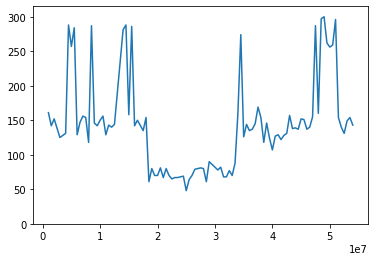

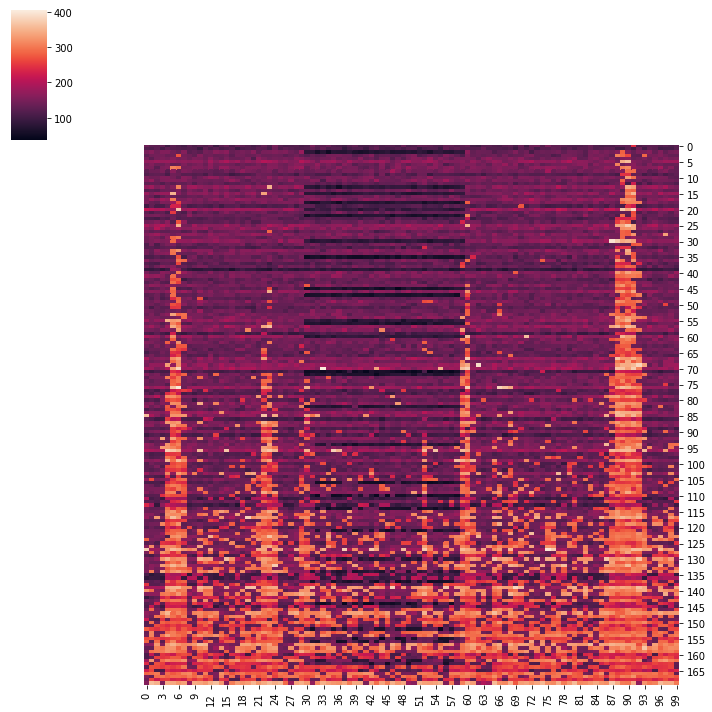

In [10]:
# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)

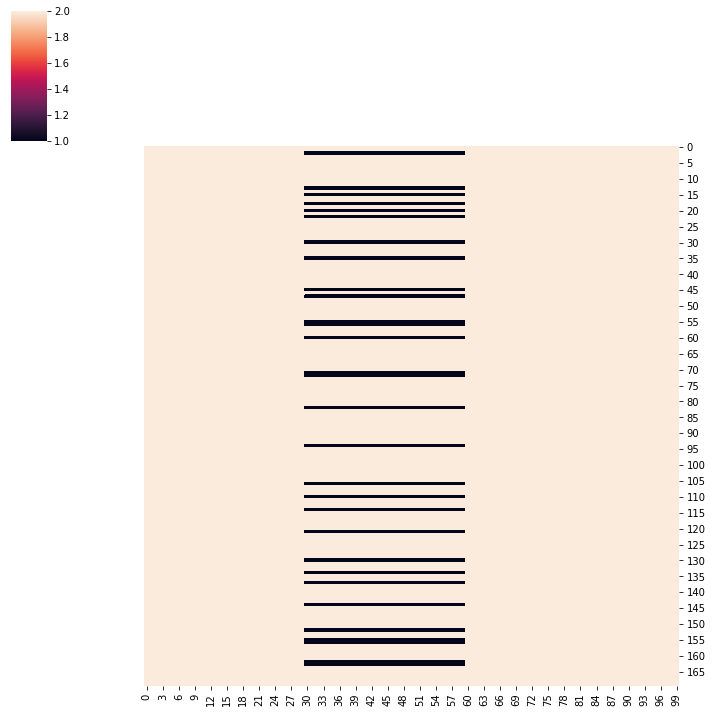

In [11]:
# visualize the true copy number heatmap
sns.clustermap(cn.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)
plt.show()

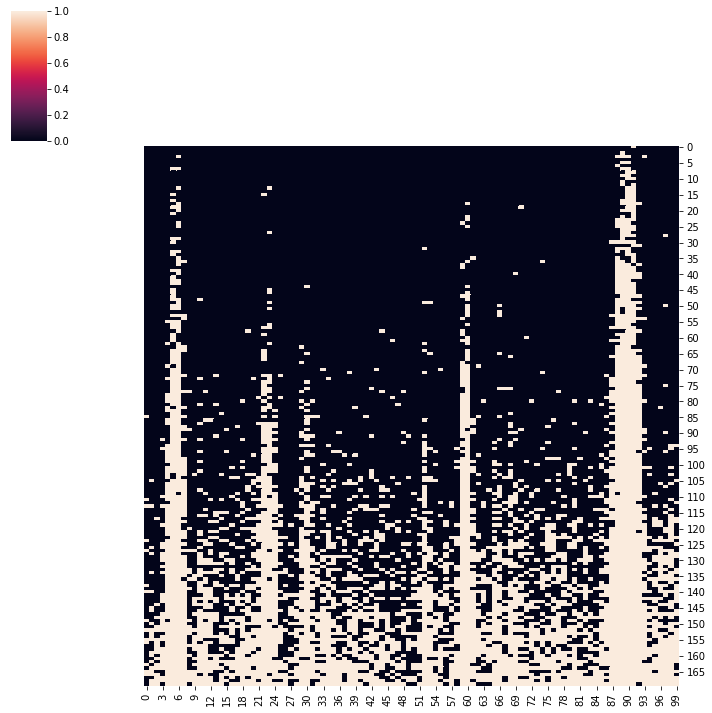

In [12]:
# visualize the true replication heatmap
sns.clustermap(rep.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


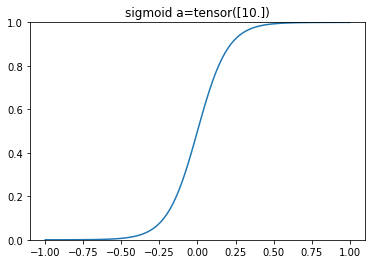

In [13]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['expose_a']['value'].detach())


### Normalize each cell to the same total number of reads

In [14]:
reads_per_cell = torch.mean(reads) * num_loci
reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
reads_norm = reads_norm.type(torch.int64)

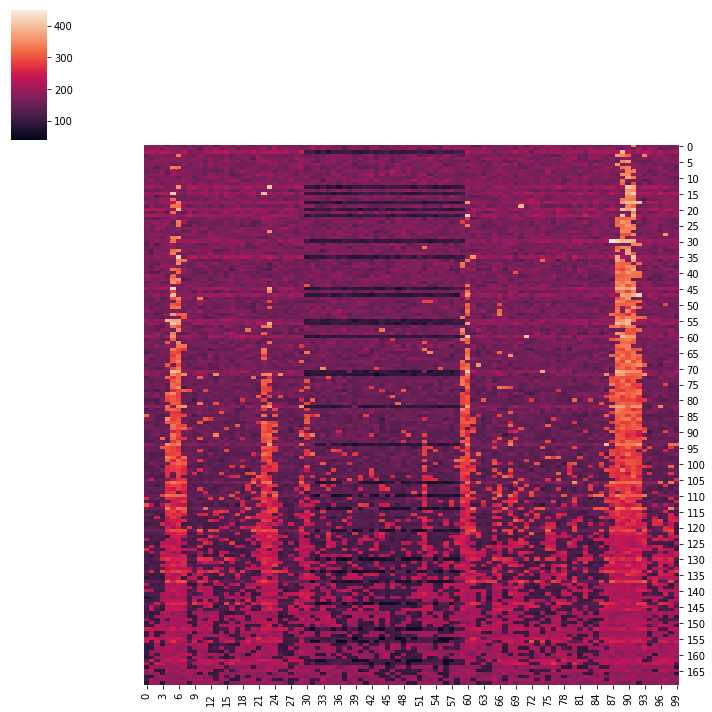

In [15]:
sns.clustermap(reads_norm.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)
plt.show()

### Infer all relevant params just taking `reads_norm` as input

In [16]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)
reads_norm = reads_norm.type(torch.float32)
trans_mat = trans_mat.type(torch.float32)
cn_prior = cn_prior.type(torch.float32)
rt = rt.type(torch.float32)

In [17]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [18]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
    })

guide = AutoDelta(
    poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [19]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)


116451.109375

In [20]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

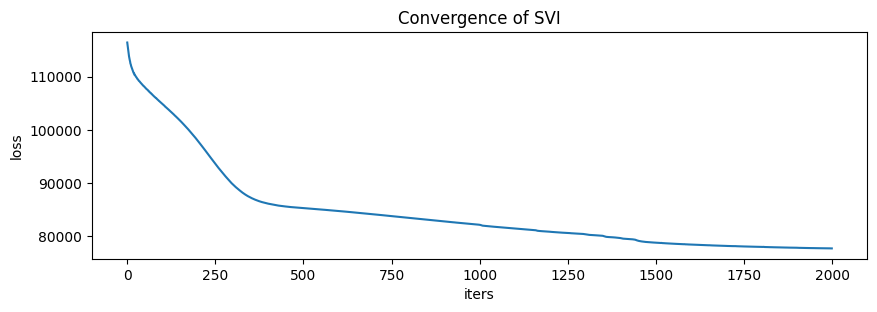

In [21]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


### Visualize model output results for `rep` and `cn`

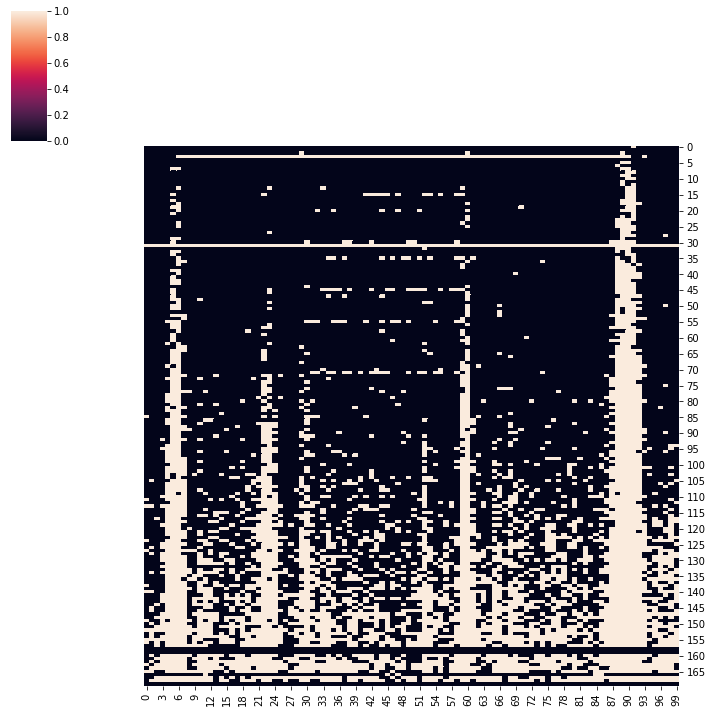

In [22]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)
trained_model = poutine.replay(conditioned_model, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3)
trace = poutine.trace(inferred_model).get_trace(data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)

model_rep = torch.zeros(cn.shape)
model_cn = torch.zeros(cn.shape)
model_rep_cn = torch.zeros(cn.shape)
model_reads = torch.zeros(cn.shape)
for l in range(num_loci):
    temp_rep = trace.nodes['rep_{}'.format(l)]['value']
    temp_cn = trace.nodes['cn_{}'.format(l)]['value']
    temp_rep_cn = temp_cn * (1. + temp_rep)
    temp_reads = trace.nodes['reads_{}'.format(l)]['value']
    model_rep[l] = temp_rep
    model_cn[l] = temp_cn
    model_rep_cn[l] = temp_rep_cn
    model_reads[l] = temp_reads

sns.clustermap(model_rep.numpy().astype(float).T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)

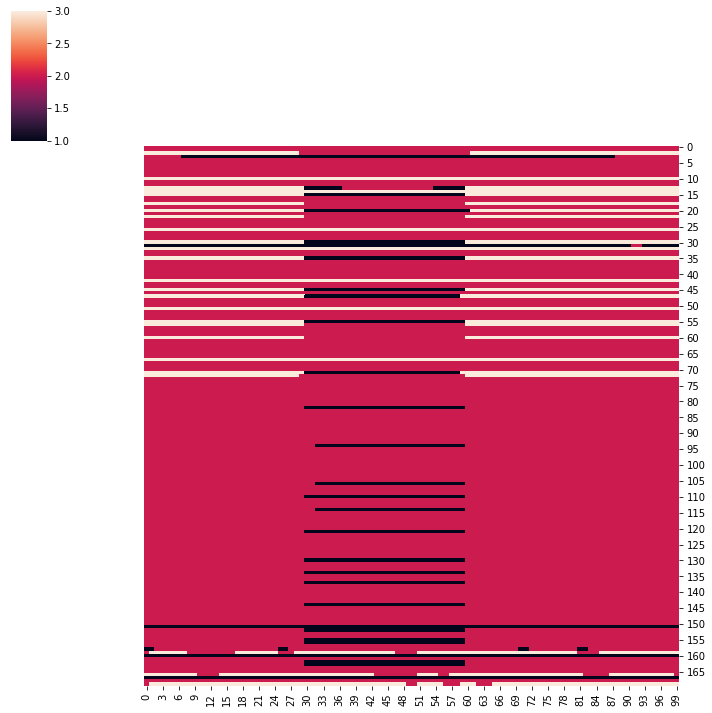

In [23]:
sns.clustermap(model_cn.numpy().astype(float).T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)
plt.show()

In [24]:
map_estimates = guide(data=reads_norm, trans_mat=trans_mat)

In [25]:
map_estimates.keys()

dict_keys(['expose_a', 'expose_rt', 'expose_time', 'expose_u'])

In [26]:
map_estimates['expose_time'].shape

torch.Size([170])

In [27]:
map_estimates['expose_rt'].shape

torch.Size([100])

In [28]:
# compute p_rep for each bin using t, rt, and a
time_diff = trace.nodes['expose_time']['value'].reshape(-1, num_cells) - trace.nodes['expose_rt']['value'].reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-trace.nodes['expose_a']['value'] * time_diff))
p_rep = p_rep.detach().numpy().astype(float)
p_rep.shape

(100, 170)

In [29]:
rep_maxprob = np.zeros(p_rep.shape)
for i in range(rep_maxprob.shape[0]):
    for j in range(rep_maxprob.shape[1]):
        rep_maxprob[i, j] = 1 if p_rep[i, j] > 0.5 else 0

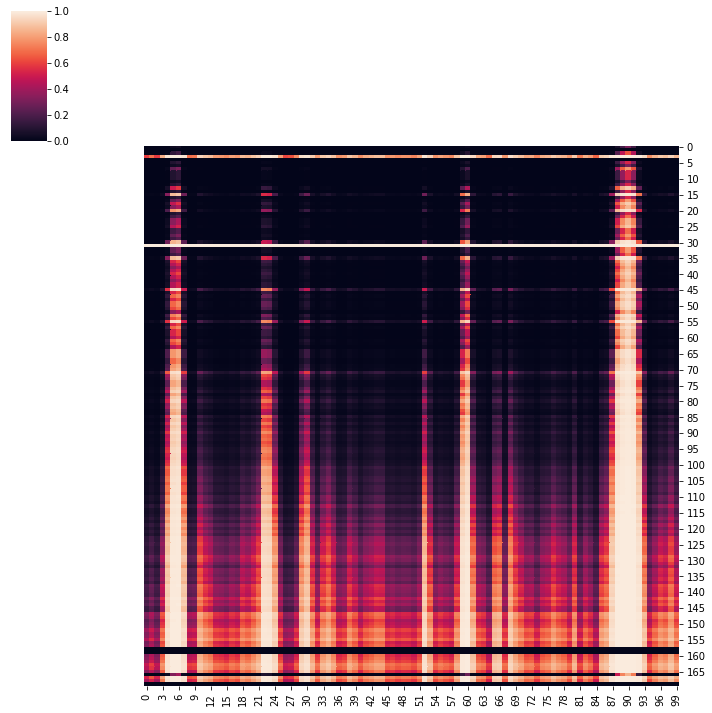

In [30]:
sns.clustermap(p_rep.T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)
plt.show()

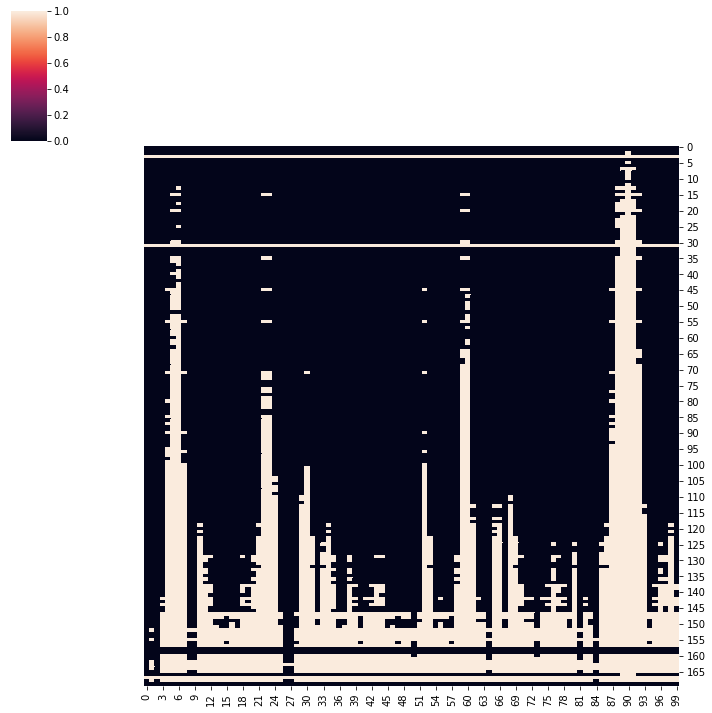

In [31]:
sns.clustermap(rep_maxprob.T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)
plt.show()

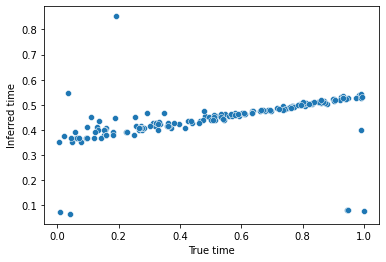

In [32]:

sns.scatterplot(
    x=time,
    y=map_estimates['expose_time'].detach().numpy(),
)
plt.xlabel('True time')
plt.ylabel('Inferred time')
plt.show()

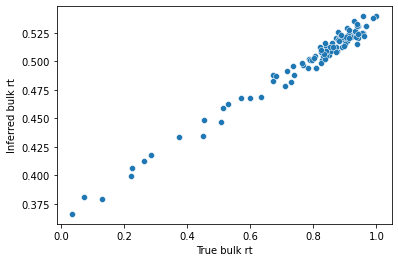

In [33]:
sns.scatterplot(
    x=rt,
    y=map_estimates['expose_rt'].detach().numpy(),
)
plt.xlabel('True bulk rt')
plt.ylabel('Inferred bulk rt')
plt.show()

In [34]:
model1_accuracy = 1.0 - (np.sum(abs(rep.numpy() - model_rep.numpy())) / (rep.shape[0] * rep.shape[1]))
model1_accuracy

0.9661176470588235

In [35]:
model1_maxprob_accuracy = 1.0 - (np.sum(abs(rep.numpy() - rep_maxprob)) / (rep.shape[0] * rep.shape[1]))
model1_maxprob_accuracy

0.851764705882353

### Now try to infer with a model that treats all loci independently (agnostic to a bulk `rt` profile)

In [36]:
u_guess = torch.mean(reads_norm) / (1.5 * torch.mean(cn))
u_guess

tensor(59.3701)

### Wrangle the true and inferred values into a dataframe

In [37]:
cn_s_out = []
for i in range(num_cells):
    temp_cn = rtdata.iloc[:num_loci]
    temp_cn['cell_id'] = 'cell_{}'.format(i)
    temp_cn['state'] = cn[:,i]
    temp_cn['reads'] = reads[:,i]
    temp_cn['reads_norm'] = reads_norm[:,i]
    temp_cn['true_rep'] = rep[:,i]
    temp_cn['true_u'] = u[i].numpy()
    temp_cn['true_time'] = time[i].numpy()
    temp_cn['true_nb_r'] = nb_r.detach().numpy()[0]
    temp_cn['true_a'] = a.numpy()[0]
    
    # results from model_S
    temp_cn['model1_rep'] = model_rep.numpy()[:,i]
    temp_cn['model1_time'] = trace.nodes["expose_time"]["value"][i].detach().numpy()
    temp_cn['model1_u'] = trace.nodes["expose_u"]["value"][i].detach().numpy()
    temp_cn['model1_nb_r'] = trace.nodes["expose_nb_r"]["value"][0].detach().numpy()
    temp_cn['model1_a'] = trace.nodes["expose_a"]["value"][0].detach().numpy()
    
    cn_s_out.append(temp_cn)
cn_s_out = pd.concat(cn_s_out, ignore_index=True)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithC

In [38]:
cn_s_out.head()

,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt,cell_id,state,reads,...,true_rep,true_u,true_time,true_nb_r,true_a,model1_rep,model1_time,model1_u,model1_nb_r,model1_a
0,1,1000000,1500000,0.598330,81.441980,500000,1.000000,cell_0,2.0,147.0,...,0.0,69.23082,0.769644,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538
1,1,1500000,2000000,0.539496,79.131013,500000,0.966776,cell_0,2.0,145.0,...,0.0,69.23082,0.769644,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538
2,1,2000000,2500000,0.594508,78.557313,500000,0.958528,cell_0,2.0,143.0,...,0.0,69.23082,0.769644,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538
3,1,3000000,3500000,0.584570,70.388076,500000,0.841080,cell_0,2.0,141.0,...,0.0,69.23082,0.769644,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538
4,1,4000000,4500000,0.482572,48.663092,500000,0.528744,cell_0,2.0,259.0,...,1.0,69.23082,0.769644,10000.000977,10.0,1.0,0.494933,71.902512,455.679596,52.875538


In [39]:
for cell_id, chunk in cn_s_out.groupby('cell_id'):
    # add fraction of replicated bins per cell
    temp_rep0 = chunk.true_rep.values
    cn_s_out.loc[chunk.index, 'true_frac_rt'] = sum(temp_rep0) / temp_rep0.shape[0]
    temp_rep1 = chunk.model1_rep.values
    cn_s_out.loc[chunk.index, 'model1_frac_rt'] = sum(temp_rep1) / temp_rep1.shape[0]
    
    # add per-cell replication state acccuracy
    accuracy1 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model1_rep'])) / chunk.shape[0])
    cn_s_out.loc[chunk.index, 'model1_rep_acc'] = accuracy1
    
cn_s_out.head()

,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt,cell_id,state,reads,...,true_nb_r,true_a,model1_rep,model1_time,model1_u,model1_nb_r,model1_a,true_frac_rt,model1_frac_rt,model1_rep_acc
0,1,1000000,1500000,0.598330,81.441980,500000,1.000000,cell_0,2.0,147.0,...,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538,0.41,0.41,1.0
1,1,1500000,2000000,0.539496,79.131013,500000,0.966776,cell_0,2.0,145.0,...,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538,0.41,0.41,1.0
2,1,2000000,2500000,0.594508,78.557313,500000,0.958528,cell_0,2.0,143.0,...,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538,0.41,0.41,1.0
3,1,3000000,3500000,0.584570,70.388076,500000,0.841080,cell_0,2.0,141.0,...,10000.000977,10.0,0.0,0.494933,71.902512,455.679596,52.875538,0.41,0.41,1.0
4,1,4000000,4500000,0.482572,48.663092,500000,0.528744,cell_0,2.0,259.0,...,10000.000977,10.0,1.0,0.494933,71.902512,455.679596,52.875538,0.41,0.41,1.0


In [40]:
cell_metrics = cn_s_out[['cell_id', 'true_a', 'true_nb_r', 'true_time', 'true_u', 'true_frac_rt', 'model1_rep_acc',
                         'model1_nb_r', 'model1_a', 'model1_time', 'model1_u', 'model1_frac_rt']].drop_duplicates()
cell_metrics.shape

(170, 12)

In [41]:
cell_metrics.head()

,cell_id,true_a,true_nb_r,true_time,true_u,true_frac_rt,model1_rep_acc,model1_nb_r,model1_a,model1_time,model1_u,model1_frac_rt
0,cell_0,10.0,10000.000977,0.769644,69.230820,0.41,1.00,455.679596,52.875538,0.494933,71.902512,0.41
100,cell_1,10.0,10000.000977,0.481434,70.573784,0.16,0.99,455.679596,52.875538,0.455642,54.358643,0.17
200,cell_2,10.0,10000.000977,0.715891,64.046242,0.33,1.00,455.679596,52.875538,0.485638,76.285538,0.33
300,cell_3,10.0,10000.000977,0.926152,63.967167,0.75,1.00,455.679596,52.875538,0.530628,57.470726,0.75
400,cell_4,10.0,10000.000977,0.803421,82.226227,0.53,1.00,455.679596,52.875538,0.507775,65.184166,0.53


In [42]:
loci_metrics = rtdata.iloc[:num_loci]
loci_metrics['true_bulk_rt'] = np.mean(rep.numpy(), axis=1)
loci_metrics['model1_bulk_rt'] = np.mean(model_rep.numpy(), axis=1)
loci_metrics.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt,true_bulk_rt,model1_bulk_rt
0,1,1000000,1500000,0.598330,81.441980,500000,1.000000,0.082353,0.082353
1,1,1500000,2000000,0.539496,79.131013,500000,0.966776,0.123529,0.111765
2,1,2000000,2500000,0.594508,78.557313,500000,0.958528,0.100000,0.082353
3,1,3000000,3500000,0.584570,70.388076,500000,0.841080,0.188235,0.182353
4,1,4000000,4500000,0.482572,48.663092,500000,0.528744,0.482353,0.464706


### Evaluate performance of model1 (same as generative)

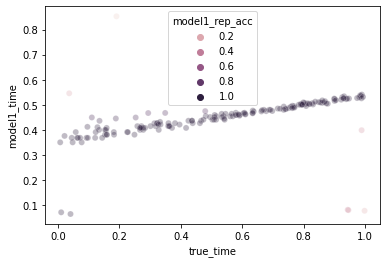

In [43]:
sns.scatterplot(data=cell_metrics, x='true_time', y='model1_time', hue='model1_rep_acc', alpha=0.3)
plt.show()

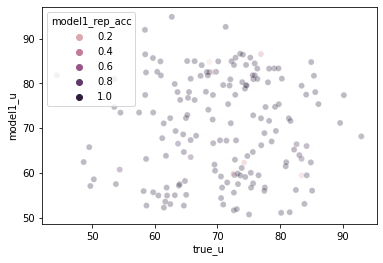

In [44]:
sns.scatterplot(data=cell_metrics, x='true_u', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()

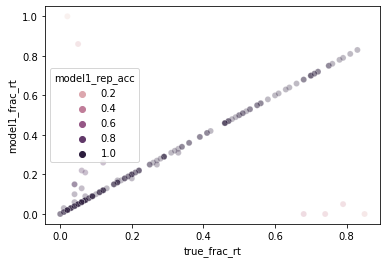

In [45]:
sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model1_frac_rt', hue='model1_rep_acc', alpha=0.3)
plt.show()

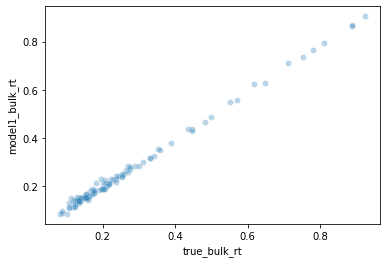

In [46]:
sns.scatterplot(data=loci_metrics, x='true_bulk_rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

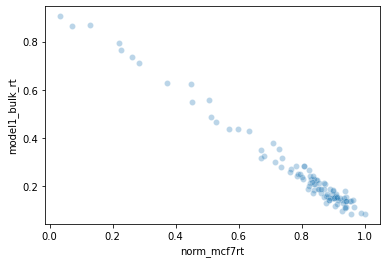

In [47]:
sns.scatterplot(data=loci_metrics, x='norm_mcf7rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

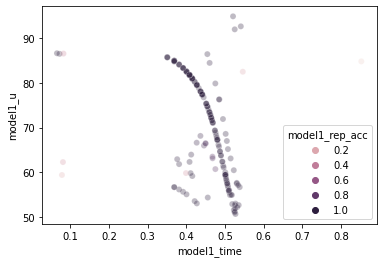

In [48]:
sns.scatterplot(data=cell_metrics, x='model1_time', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()

### Look at the inferred transition matrix to see if it makes sense

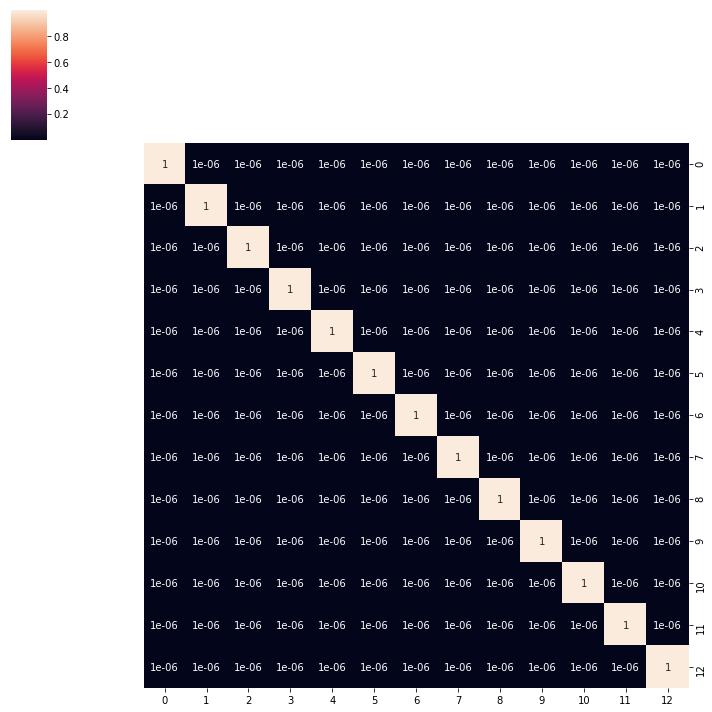

In [49]:
# sns.clustermap(map_estimates['expose_trans_prob'].detach().numpy(),
#                col_cluster=False, row_cluster=False, annot=True)
sns.clustermap(trans_mat.numpy(), col_cluster=False, row_cluster=False, annot=True)
plt.show()

### Build viterbi decoder instead of relying on `poutine.trace()`

In [50]:
@infer_discrete(first_available_dim=-3, temperature=0)
@config_enumerate
def viterbi_decoder(cell_reads, trans_mat, a, nb_r, time, u, rt):
    (num_loci,) = cell_reads.shape
    cn = 2
    cn_states = []
    rep_states = []
    for l in pyro.markov(range(num_loci)):
        
        temp_cn_prob = trans_mat[cn]
        cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob))

        # per cell per bin late or early 
        time_diff = time - rt[l]

        # probability of having been replicated
        p_rep = 1 / (1 + torch.exp(-a * time_diff))

        # binary replicated indicator
        rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))

        # copy number accounting for replication
        rep_cn = cn * (1. + rep)

        # expected reads per bin per cell
        expected_reads = (u * rep_cn)

        nb_p = expected_reads / (expected_reads + nb_r)

        reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=cell_reads[l])
        
        cn_states.append(cn)
        rep_states.append(rep)
        
    return cn_states, rep_states  # returns maximum likelihood states

vit_cn_states = []
vit_rep_states = []
for i in range(reads.shape[1]):
    cell_reads = reads[:, i]
    cell_time = trace.nodes["expose_time"]["value"][i]
    cell_u = trace.nodes["expose_u"]["value"][i]
    temp_cn_states, temp_rep_states = viterbi_decoder(
        cell_reads, trans_mat, trace.nodes["expose_a"]["value"], trace.nodes["expose_nb_r"]["value"],
        cell_time, cell_u, trace.nodes["expose_rt"]["value"]
    )
    vit_cn_states.append(torch.stack(temp_cn_states))
    vit_rep_states.append(torch.stack(temp_rep_states))

vit_cn_states = torch.stack(vit_cn_states)
vit_rep_states = torch.stack(vit_rep_states)
vit_rep_states.shape

torch.Size([170, 100])

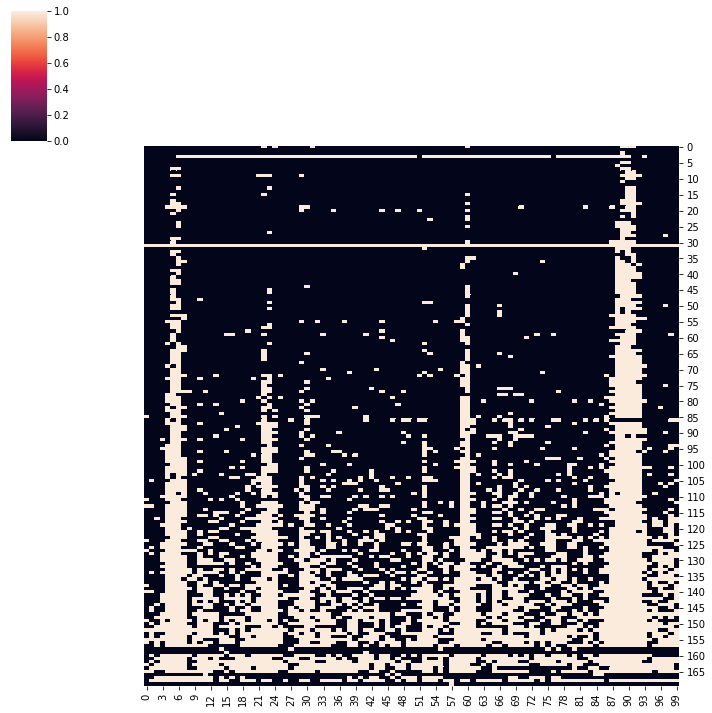

In [51]:
sns.clustermap(vit_rep_states.numpy().astype(float)[np.argsort(time), :],
               col_cluster=False, row_cluster=False)

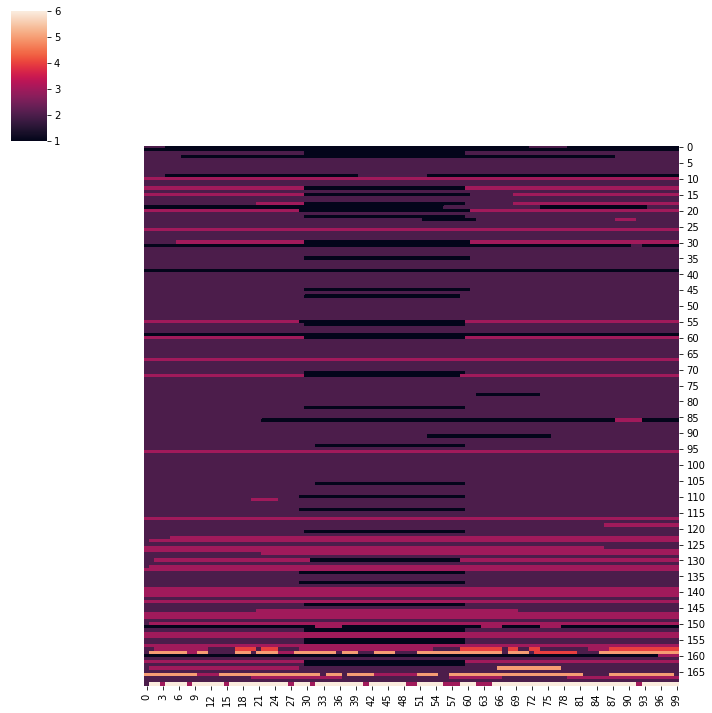

In [52]:
sns.clustermap(vit_cn_states.numpy().astype(float)[np.argsort(time), :],
               col_cluster=False, row_cluster=False)